# Introduction

Test and training data with their associated labels have been acquired from an academic dataset (not available in this repo due to size >700MB). The actual content of these datasets is not entirely certain, but likely to be small image data labelled into several categories. The goal is to build neural network models with PyTorch that classify the data to the labels.  
Initially, a simple neural network is built, followed by a convolutional neural network. These are run here on a CPU, but the code is written to run on a GPU where available.

# Prepare the data

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm

In [2]:
# Load the data
train_data = torch.load('train_data_2')
test_data = torch.load('test_data_2')

train_labels = torch.load('train_labels_2').long()
test_labels = torch.load('test_labels_2').long()

## EDA

In [3]:
# Check the shape of the data
train_data.shape, test_data.shape

(torch.Size([50000, 3, 32, 32]), torch.Size([10000, 3, 32, 32]))

The data appears to be colour images (3 channel) of 32x32 pixels. We can test this by plotting a sample.

The Corresponding Label is: 7


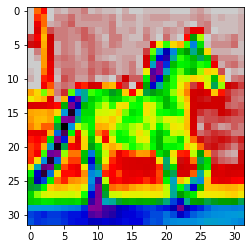

In [4]:
import matplotlib.pyplot as plt
sample_num=141
print(f'The Corresponding Label is: {train_labels[sample_num]}')
plt.imshow(train_data[sample_num][0], cmap='nipy_spectral')
plt.show()

This is clearly an image of a horse, despite being unable to find the exact colourmap to a make it look natural. It is worth examining the labels to have an idea of how many categories this data is to be classified into.

In [5]:
# Find the min and max values of the labels
min(train_labels), max(train_labels)

(tensor(0), tensor(9))

There appear to be 10 output categories for this data, so the neural network should have 10 outputs.
Additionally, the data needs to be flattened before use in the neural network.

In [6]:
# Flatten data tensors
train_data = train_data.view(train_data.shape[0], train_data.shape[1] * train_data.shape[2] * train_data.shape[3])
test_data = test_data.view(test_data.shape[0], test_data.shape[1] * test_data.shape[2] * test_data.shape[3])

In [7]:
# Check data shapes and types are correct for PyTorch
print(train_data.shape, test_data.shape)
print(train_data.type(), test_data.type())
print(train_labels.type(), test_labels.type())

torch.Size([50000, 3072]) torch.Size([10000, 3072])
torch.FloatTensor torch.FloatTensor
torch.LongTensor torch.LongTensor


# Simple Neural Network

## Build and train

In [8]:
# Define the parameters of the simple neural network
class Simple_NN(nn.Module):
    
    def __init__(self, n_features):
        super().__init__()
        self.fc1 = nn.Linear(n_features, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x)) # ReLU activation function used for hidden layers
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        # Log softmax is an activation function that normalizes the category scores, and the log also increases penalty of incorrect classification
        x = F.log_softmax(self.fc4(x), dim = 1)
        return x

In [9]:
# Push processing onto GPU if available
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("running on the GPU")
else:
    device = torch.device("cpu")
    print("running on the CPU")

net = Simple_NN(n_features = 3072)
net.to(device)

running on the CPU


Simple_NN(
  (fc1): Linear(in_features=3072, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)

In [10]:
# Define loss function and optimizer to use
loss_function = nn.CrossEntropyLoss()
optimizer =  torch.optim.SGD(net.parameters(), lr=0.1)

In [11]:
epochs = 20
BATCH_SIZE = 100
for epoch in range (epochs):
    for i in tqdm(range(0,len(train_data), BATCH_SIZE)): # Use tqdm to show progress bars
        # Batch the data
        batch_data = train_data[i:i+BATCH_SIZE]
        batch_labels = train_labels[i:i+BATCH_SIZE]
        batch_data = batch_data.to(device)
        batch_labels = batch_labels.to(device)
        
        net.zero_grad()  # Set gradients to 0 before loss calculation
        output = net(batch_data)  # Pass in the reshaped batch
        
        loss = loss_function(output, batch_labels)  # Calculate the loss value
        loss.backward()  # Apply the loss backwards through the network's parameters
        optimizer.step()  # Optimize weights to account for loss/gradients
    
    print(loss)

  2%|▏         | 8/500 [00:00<00:06, 76.35it/s]

tensor(1.8367, grad_fn=<NllLossBackward>)


  2%|▏         | 8/500 [00:00<00:06, 78.84it/s]

tensor(1.7420, grad_fn=<NllLossBackward>)


  1%|          | 6/500 [00:00<00:08, 58.93it/s]

tensor(1.7305, grad_fn=<NllLossBackward>)


  1%|          | 6/500 [00:00<00:08, 58.24it/s]

tensor(1.6846, grad_fn=<NllLossBackward>)


  2%|▏         | 9/500 [00:00<00:05, 83.48it/s]

tensor(1.6278, grad_fn=<NllLossBackward>)


  1%|          | 6/500 [00:00<00:08, 57.46it/s]

tensor(1.5544, grad_fn=<NllLossBackward>)


  2%|▏         | 9/500 [00:00<00:05, 83.35it/s]

tensor(1.5473, grad_fn=<NllLossBackward>)


  2%|▏         | 8/500 [00:00<00:06, 75.23it/s]

tensor(1.4593, grad_fn=<NllLossBackward>)


  2%|▏         | 9/500 [00:00<00:05, 83.62it/s]

tensor(1.4442, grad_fn=<NllLossBackward>)


  2%|▏         | 9/500 [00:00<00:05, 86.85it/s]

tensor(1.3929, grad_fn=<NllLossBackward>)


  2%|▏         | 9/500 [00:00<00:05, 89.70it/s]

tensor(1.3733, grad_fn=<NllLossBackward>)


  2%|▏         | 9/500 [00:00<00:06, 81.30it/s]

tensor(1.3148, grad_fn=<NllLossBackward>)


  1%|▏         | 7/500 [00:00<00:07, 69.85it/s]

tensor(1.3019, grad_fn=<NllLossBackward>)


  2%|▏         | 8/500 [00:00<00:06, 75.97it/s]

tensor(1.2390, grad_fn=<NllLossBackward>)


  2%|▏         | 9/500 [00:00<00:05, 86.73it/s]

tensor(1.2757, grad_fn=<NllLossBackward>)


  1%|          | 6/500 [00:00<00:08, 58.26it/s]

tensor(1.2307, grad_fn=<NllLossBackward>)


  2%|▏         | 8/500 [00:00<00:06, 77.53it/s]

tensor(1.1659, grad_fn=<NllLossBackward>)


  2%|▏         | 9/500 [00:00<00:05, 86.37it/s]

tensor(1.1537, grad_fn=<NllLossBackward>)


  2%|▏         | 8/500 [00:00<00:06, 77.86it/s]

tensor(1.1802, grad_fn=<NllLossBackward>)


100%|██████████| 500/500 [00:05<00:00, 86.73it/s]

tensor(1.1142, grad_fn=<NllLossBackward>)


## Predict

In [12]:
# Use the model to predict from the test set
with torch.no_grad():
    predicted = net.forward(test_data.to(device))
    predicted_classes = torch.argmax(predicted, dim = 1)
    
    # The model seems to predict fairly well but still makes some mistakes
    print(predicted_classes[0:10])
    print(test_labels[0:10])
    
# Push data back onto CPU for further analysis
device = torch.device('cpu')
predicted_classes = predicted_classes.to(device)
test_labels = test_labels.to(device)

tensor([4, 9, 8, 0, 4, 6, 3, 6, 3, 1])
tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1])


In [13]:
# Find accuracy metric for prediction on test set
correct = 0
total = 0
for i in range(len(predicted_classes)):

    if predicted_classes[i] == test_labels[i]:
        correct += 1
    total += 1
print("Accuracy: ", round(correct/total, 3))

Accuracy:  0.504


This model has given 50% accuracy. This can be compared to a convolutional model to see if this can be improved.

# Convolutional Neural Network

## Reload the data

In [14]:
# As the data was previously converted to the long format, this loses 2d spatial information. The data is therefore reloaded
train_data = torch.load('train_data_2')
test_data = torch.load('test_data_2')
train_data.shape, test_data.shape

(torch.Size([50000, 3, 32, 32]), torch.Size([10000, 3, 32, 32]))

## Build and train

In [15]:
# A 2-dimensional CNN is used as this typically performs best with 2D image data

class Conv_NN(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        
        self.cnn_layers = nn.Sequential(
            # Define a 2D convolution layer
            nn.Conv2d(in_channels = n_channels, out_channels = 16, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(16), # Batch normalisation standardises inputs to improve training performance
            nn.ReLU(inplace=True), # Using the same activation function as with the Simple NN
            nn.MaxPool2d(kernel_size=2, stride=2), # Max pooling to help extract sharp features e.g. edges
            # Define another 2D convolution layer
            nn.Conv2d(16, 8, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=2, stride=2) # Average pooling to help extract smooth image features
        )
        
        # Add linear layers to get to 10 outputs
        self.linear_layers = nn.Sequential(
            nn.Flatten(), # Flatten the input
            nn.Linear(200, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10)
        )

    # Define the forward function
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x    


In [16]:
# Instantiate the model and check the steps
net = Conv_NN(n_channels = 3)
print(net)

Conv_NN(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 8, kernel_size=(4, 4), stride=(1, 1))
    (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (linear_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=200, out_features=100, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=100, out_features=10, bias=True)
  )
)


In [17]:
# Push processing onto GPU if available
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("running on the GPU")
else:
    device = torch.device("cpu")
    print("running on the CPU")

net.to(device)

running on the CPU


Conv_NN(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 8, kernel_size=(4, 4), stride=(1, 1))
    (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (linear_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=200, out_features=100, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [18]:
# Define loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

In [19]:
epochs = 10
BATCH_SIZE = 25
for epoch in range (epochs):
    for i in tqdm(range(0,len(train_data), BATCH_SIZE)): # Use tqdm to show progress bars
        # Batch the data
        batch_data = train_data[i:i+BATCH_SIZE]
        batch_labels = train_labels[i:i+BATCH_SIZE]
        batch_data = batch_data.to(device)
        batch_labels = batch_labels.to(device)
        
        net.zero_grad()  # Set gradients to 0 before loss calculation
        output = net(batch_data)  # Pass in the batch
        
        loss = loss_function(output, batch_labels)  # Calculate the loss value
        loss.backward()  # Apply the loss backwards through the network's parameters
        optimizer.step()  # Optimize weights to account for loss/gradients
    
    print(loss)

  0%|          | 0/2000 [00:00<?, ?it/s]/home/fj/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448216815/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
  0%|          | 6/2000 [00:00<00:37, 53.71it/s]

tensor(1.4888, grad_fn=<NllLossBackward>)


  0%|          | 6/2000 [00:00<00:36, 54.47it/s]

tensor(1.1524, grad_fn=<NllLossBackward>)


  0%|          | 5/2000 [00:00<00:47, 42.37it/s]

tensor(1.0947, grad_fn=<NllLossBackward>)


  0%|          | 5/2000 [00:00<00:44, 44.74it/s]

tensor(1.0893, grad_fn=<NllLossBackward>)


  0%|          | 5/2000 [00:00<00:46, 42.51it/s]

tensor(1.0842, grad_fn=<NllLossBackward>)


  0%|          | 4/2000 [00:00<00:49, 39.99it/s]

tensor(1.1312, grad_fn=<NllLossBackward>)


  0%|          | 6/2000 [00:00<00:33, 59.88it/s]

tensor(1.1653, grad_fn=<NllLossBackward>)


  0%|          | 5/2000 [00:00<00:40, 49.60it/s]

tensor(1.1587, grad_fn=<NllLossBackward>)


  0%|          | 4/2000 [00:00<00:51, 39.06it/s]

tensor(1.1236, grad_fn=<NllLossBackward>)


100%|██████████| 2000/2000 [00:32<00:00, 60.61it/s]

tensor(1.1089, grad_fn=<NllLossBackward>)


## Predict

In [20]:
# Use the model to predict from the test set
with torch.no_grad():
    predicted = net.forward(test_data.to(device))
    predicted_classes = torch.argmax(predicted, dim = 1)
    
    # The model seems to predict well with fewer mistakes
    print(predicted_classes[0:10])
    print(test_labels[0:10])
    
# Push data back onto CPU for further analysis
device = torch.device('cpu')
predicted_classes = predicted_classes.to(device)
test_labels = test_labels.to(device)

tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 9])
tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1])


In [21]:
# Find accuracy metric for prediction on test set
correct = 0
total = 0
for i in range(len(predicted_classes)):

    if predicted_classes[i] == test_labels[i]:
        correct += 1
    total += 1
print("Accuracy: ", round(correct/total, 3))

Accuracy:  0.638


In [22]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_labels, predicted_classes)

array([[653,  29,  70,  21,  29,   5,  10,  15, 121,  47],
       [ 27, 790,  13,   3,   7,   5,  12,   5,  39,  99],
       [ 70,  13, 482,  62, 117,  59,  99,  61,  23,  14],
       [ 25,  20,  86, 396, 115, 121, 121,  72,  22,  22],
       [ 21,  12,  81,  52, 575,  18, 108, 106,  20,   7],
       [ 17,   7,  88, 206,  61, 440,  54, 109,   9,   9],
       [  6,   4,  36,  42,  42,  13, 832,  10,  10,   5],
       [ 22,   8,  37,  42,  71,  40,  19, 735,   2,  24],
       [ 90,  63,  11,  27,  13,   3,  10,   7, 728,  48],
       [ 34,  87,   7,  10,   9,   2,  17,  35,  51, 748]])

The convolutional model has given a good increase over the simple NN, now up to 64% accuracy. It appears that classes 2, 3, and 4 were more difficult to classify, showing misclassifications into several classes. Also, there are noticeable peaks in misclassification where class 8 and class 0 have been misclassified as each other, as were classes 5 and 3, and classes 9 and 1. This suggests there may be some common features between these class pairs that the model is identifying and causing the misclassifications observed.

# Conclusion

Both models performed fairly well once optimized. One noticeable issue worth mentioning with the simple NN was the learning rate used, which was relatively high. Looking at the error values, after a certain number of epochs we saw that learning rates actually increased slightly, and the final model did not have the lowest error of all the epochs. This would suggest that the model was overadjusting in gradient descent and overshooting the minimum error of the model. However, the higher learning rate did bring the error down quickly in earlier epochs, so a stepped learning rate could be useful here, e.g. by using the StepLR or MultiStepLR function in the optimizer. Alternatively, it appears that a learning rate schedule that uses decay or momentum, e.g. the Adam optimizer, could significantly benefit this model in helping it to converge.  

This strategy could also be applied to the CNN to hone in on a minimum for the error function. However, the CNN was significantly reducing error over each epoch, so a first strategy to improving the CNN model may simply be to run more epochs, with the possible addition of a more complex learning rate schedule.

# References

1) https://www.freecodecamp.org/news/an-intuitive-guide-to-convolutional-neural-networks-260c2de0a050/  
2) https://www.analyticsvidhya.com/blog/2019/10/building-image-classification-models-cnn-pytorch/  
3) https://pytorch.org/docs/stable/generated/torch.nn.Module.html  
4) https://www.geeksforgeeks.org/adjusting-learning-rate-of-a-neural-network-in-pytorch/